## Daymet

### Resources

- Working with netCDF files: https://towardsdatascience.com/read-netcdf-data-with-python-901f7ff61648
- NetCDF4 documentation: https://unidata.github.io/netcdf4-python/
- Daymet data description: https://daac.ornl.gov/DAYMET/guides/Daymet_V4_Stn_Level_CrossVal.html


### Data Description:
- Daily weather observation data and cross-validation results for three Daymet model parameters: min temp, max temp, and daily precipitation
- Observations are from multiple stations within the same region.
- The North American region includes Canada, United States, and Mexico. The data for the North American region spans 1980-present.
- Also included are corresponding station metadata files listing every surface weather station used in Daymet processing for each parameter, region, and year and containing the station name, station identification, latitude, and longitude.
- There are 468 netCDF files that contain the daily input observations and cross-validation results. Each variable-region-year combination is a separate file. 
- There are 126 files each for North America and Hawaii, and 216 files for Puerto Rico. 
- Provided as additional files, are 468 corresponding text files (.txt) that contain metadata for every surface weather station used in Daymet processing for the variable-region-year combinations. 
- Filename format: daymet_v4_stnxval_pppp_region_yyyy.nc, where
    - pppp: is the respective meteorological variable (tmax, tmin, and prcp)
    - region: is 'na' (for continental North America), 'hi' (for Hawaii), or 'pr' (for Puerto Rico), and
    - yyyy: is year (1950 through 2021).  
- Parameters in the netCDF file
    - station_id: The ground weather station identification (as a string value) as extracted from the GHCN-Daily input files.
    - station_name: The ground weather station name (as a string value) as extracted from the GHCN-Daily input files.
    - stnz (meters): The station elevation reported in the metadata readme as extracted from the GHCN-Daily input files.
    - time (day): The day number since the beginning of the dataset. Data are in a daily time step, defined as 24-hour day based on local time from mid-night to mid-night.
    - time_bnds (day): The start and end time points for each day (24-hr period based on local time).
    - stns: An integer station index within the netCDF file.
    - stn_lon (decimal degrees): The station longitude in WGS 84 (EPSG:4326) reported in the metadata readme as extracted from the GHCN-Daily input files.
    - stn_lat (decimal degrees): The station latitude in WGS 84 (EPSG:4326) reported in the metadata readme as extracted from the GHCN-Daily input files.
- Parameters specific to the precipitation netCDF file
    - obs (mm): Station observed daily total precipitation in millimeters, sum of all forms converted to water-equivalent. Data are in a daily time step, defined as 24-hour day based on local time from mid-night to mid-night.
    - pred (mm): Daymet model predicted daily total precipitation in millimeters, using Daymet’s cross-validation protocol, sum of all forms converted to water-equivalent. Data are in a daily time step, defined as 24-hour day based on local time from mid-night to mid-night.
- Parameters specific to maximum and minimum temperature netCDF files
    - obs (degrees C): Station observed daily maximum (or minimum respective of file) 2-meter air temperature in degrees Celsius.  Data are in a daily time step, defined as 24-hour day based on local time from mid-night to mid-night.
    - pred (degrees C): Daymet model predicted daily maximum (or minimum respective of file) 2 m air temperature in degrees Celsius using Daymet’s cross-validation protocol.  Data are in a daily time step, defined as 24-hour day based on local time from mid-night to mid-night.

In [2]:
import glob
import pandas as pd
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 12,5

import warnings
warnings.simplefilter('ignore')

In [3]:
def get_station_ids(data, colname='station_id'):
    arr = data.variables[colname][:]
    stations = list()
    for v, m in zip(ma.getdata(arr), ma.getmask(arr)):
        station = ''.join(v[~m].astype('U13').tolist())
        stations.append(station)
    return stations

def get_station_names(data, colname='station_name'):
    arr = data.variables[colname][:]
    stations = list()
    for v in ma.getdata(arr):
        station = ''.join(v.astype('U13').tolist()).strip()
        stations.append(station)
    return stations

In [4]:
# station information
def get_station_df(data):
    station_ids = get_station_ids(data, colname='station_id')
    station_names = get_station_names(data, colname='station_name')
    station_elevation = ma.getdata(data.variables['stnz'][:])
    station_lon = ma.getdata(data.variables['stn_lon'][:])
    station_lat = ma.getdata(data.variables['stn_lat'][:])
    station_int_index = ma.getdata(data.variables['stns'][:])

    # for i in [station_ids, station_names, station_elevation, station_int_index]:
    #     print(f'number of rows: {len(i)}')

    station_df = pd.DataFrame()
    station_df['station_id'] = station_ids
    station_df['station_name'] = station_names
    station_df['stn_lon'] = station_lon
    station_df['stn_lat'] = station_lat
    station_df['stnz'] = station_elevation
    station_df['key'] = 1
    
    return station_df

In [5]:
# time data
def get_time_df(data):
    time = ma.getdata(data.variables['time'][:])
    time_bnds = ma.getdata(data.variables['time_bnds'][:])


    time_df = pd.DataFrame()
    time_df['time'] = time
    time_df['time_bnds_lower'] = [i[0] for i in time_bnds]
    time_df['time_bnds_upper'] = [i[1] for i in time_bnds]
    time_df['key'] = 1
    return time_df

In [6]:
# na_files = glob.glob('Daymet_V4_Stn_Level_CrossVal_1850/data/daymet_v4_stnxval_prcp_na_*.nc')
hi_files = glob.glob('Daymet_V4_Stn_Level_CrossVal_1850/data/daymet_v4_stnxval_prcp_hi_*.nc')
# pr_files = glob.glob('Daymet_V4_Stn_Level_CrossVal_1850/data/daymet_v4_stnxval_prcp_pr_*.nc')

In [7]:
hi_files[:2]

['Daymet_V4_Stn_Level_CrossVal_1850/data\\daymet_v4_stnxval_prcp_hi_1980.nc',
 'Daymet_V4_Stn_Level_CrossVal_1850/data\\daymet_v4_stnxval_prcp_hi_1981.nc']

In [8]:
# variables = ['station_id', 'station_name', 'stnz', 'time', 'time_bnds', 'stns', 'stn_lon', 'stn_lat', 'pred', 'obs']
station_cols = ['station_id', 'station_name', 'stn_lon', 'stn_lat', 'stnz', 'key']
time_cols = ['time', 'time_bnds_lower', 'time_bnds_upper', 'key']

all_station_df = pd.DataFrame(columns=station_cols)
all_time_df = pd.DataFrame(columns=time_cols)
all_preds_df = pd.DataFrame()
all_obs_df = pd.DataFrame()
all_preds_obs_df = pd.DataFrame()

for file in hi_files:
    data = nc.Dataset(file, 'r', format='NETCDF4_CLASSIC')
    data.variables.keys()

    station_df = get_station_df(data)
    station_df['year'] = file[65:69]
    # time_df = get_time_df(data)
    
    all_station_df = pd.concat([all_station_df, station_df])
    # all_time_df = pd.concat([all_time_df, time_df])
    
    #columns
    cols = ['station_id', 'station_name', 'year']
    for i in range(0,365):
        cols.append(i)
    
    # obs and pred data
    pred = ma.getdata(data.variables['pred'][:])
    pred_df = pd.DataFrame(pred)#.T, columns=station_df['station_id'])
    pred_df['year'] = file[65:69]
    pred_df['station_id'] = get_station_ids(data)
    pred_df['station_name'] = get_station_names(data)
    pred_df = pred_df[cols]
    all_preds_df = pd.concat([all_preds_df, pred_df])
    
    obs = ma.getdata(data.variables['obs'][:])
    obs_df = pd.DataFrame(obs)#.T, columns=station_df['station_id'])
    obs_df['year'] = file[65:69]
    obs_df['station_id'] = get_station_ids(data)
    obs_df['station_name'] = get_station_names(data)
    obs_df = obs_df[cols]
    all_obs_df = pd.concat([all_obs_df, obs_df])

In [9]:
# stations with last 5 years of data
years = ['2017','2018', '2019','2020', '2021']
sid_last_5_years = list()
for sid in all_station_df['station_id'].unique():
    temp_df = all_station_df[all_station_df['station_id']==sid][['station_id','year']]
    temp_df = temp_df[temp_df['year'].isin(years)]
    if len(temp_df)==5:
        sid_last_5_years.append(temp_df.iloc[0][0])
station_with_last_5_years = all_station_df[(all_station_df['station_id'].isin(sid_last_5_years)) & (all_station_df['year']>'2016')]

In [10]:
station_with_last_5_years.head()

,station_id,station_name,stn_lon,stn_lat,stnz,key,year
2,US1HIKI0005,KAPAA 1.4 W,-159.376,22.0936,138.7,1,2017
3,US1HIKI0006,KILAUEA 0.5 SE,-159.405,22.2057,78.9,1,2017
5,US1HIKI0019,KAPAA 1.9 WSW,-159.379,22.0829,157.0,1,2017
6,US1HIKI0021,ANAHOLA 2.8 N,-159.324,22.1869,73.8,1,2017
8,US1HIKI0024,HANALEI 3.0 W,-159.549,22.2103,6.4,1,2017


In [42]:
len(station_with_last_5_years)
len(sid_last_5_years)
len(all_station_df.station_id.unique())

368

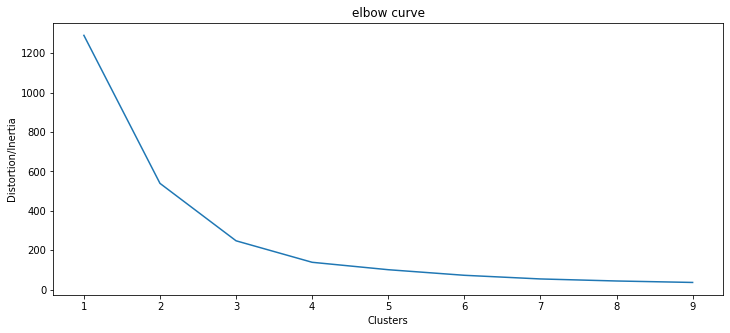

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


x = station_with_last_5_years[['stn_lon', 'stn_lat', 'stnz']]
scaler = StandardScaler()
x = scaler.fit_transform(x)


distortion = list()
n_cluster = range(1,10)
for n in n_cluster:
    kmeans = KMeans(n_clusters=n, random_state=100)
    kmeans.fit(x)
    distortion.append(kmeans.inertia_)
plt.plot(n_cluster, distortion)
plt.ylabel('Distortion/Inertia')
plt.xlabel('Clusters')
plt.title('elbow curve')
plt.show()

In [44]:
kmeans = KMeans(n_clusters=3, random_state=100)
kmeans.fit(x)
clusters = kmeans.cluster_centers_

In [14]:
# kmeans.labels_

In [45]:
x_df = pd.DataFrame(x, columns=['stn_lon', 'stn_lat', 'stnz'])
x_df['station_id'] = station_with_last_5_years['station_id'].values
x_df['labels'] =  kmeans.labels_

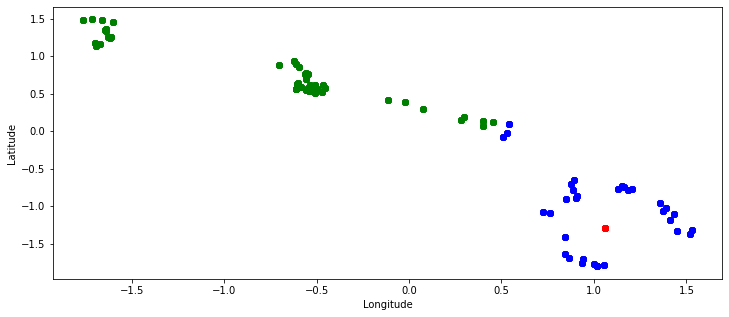

In [46]:
# for i, j in zip([0,1,2], ['blue', 'green', 'red']):
x1 = x_df[x_df['labels']==0]['stn_lon']
y1 = x_df[x_df['labels']==0]['stn_lat']
x2 = x_df[x_df['labels']==1]['stn_lon']
y2 = x_df[x_df['labels']==1]['stn_lat']
x3 = x_df[x_df['labels']==2]['stn_lon']
y3 = x_df[x_df['labels']==2]['stn_lat']
# x4 = x_df[x_df['labels']==3]['stn_lon']
# y4 = x_df[x_df['labels']==3]['stn_lat']
# x5 = x_df[x_df['labels']==4]['stn_lon']
# y5 = x_df[x_df['labels']==4]['stn_lat']
plt.scatter(x1, y1, color='red')
plt.scatter(x2, y2, color='green')
plt.scatter(x3, y3, color='blue')
# plt.scatter(x4, y4, color='orange')
# plt.scatter(x5, y5, color='b')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

In [47]:
cluster_1 = x_df[x_df['labels']==0][['station_id', 'stn_lon', 'stn_lat', 'stnz']]
cluster_1.iloc[:, [1,2,3]] = scaler.inverse_transform(cluster_1.iloc[:,[1,2,3]])

cluster_2 = x_df[x_df['labels']==1][['station_id', 'stn_lon', 'stn_lat', 'stnz']]
cluster_2.iloc[:, [1,2,3]] = scaler.inverse_transform(cluster_2.iloc[:,[1,2,3]])

cluster_3 = x_df[x_df['labels']==2][['station_id', 'stn_lon', 'stn_lat', 'stnz']]
cluster_3.iloc[:, [1,2,3]] = scaler.inverse_transform(cluster_3.iloc[:,[1,2,3]])

# cluster_4 = x_df[x_df['labels']==3][['station_id', 'stn_lon', 'stn_lat', 'stnz']]
# cluster_4.iloc[:, [1,2,3]] = scaler.inverse_transform(cluster_4.iloc[:,[1,2,3]])

In [51]:
for i in [cluster_1.station_id.unique(),cluster_2.station_id.unique(),cluster_3.station_id.unique()]:
    print(len(i))

2
51
33


In [52]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")

In [54]:
clusters = list()
cluster_1_tmp =  cluster_1.drop_duplicates(subset=['station_id'], keep='last')
cluster_2_tmp =  cluster_2.drop_duplicates(subset=['station_id'], keep='last')
cluster_3_tmp =  cluster_3.drop_duplicates(subset=['station_id'], keep='last')
# cluster_4_tmp =  cluster_4.drop_duplicates(subset=['station_id'], keep='last')

for cluster in [cluster_1_tmp, cluster_2_tmp, cluster_3_tmp]:
    states = list()
    counties = list()
    countries = list()
    for row in cluster.iterrows():
        lon = row[1].iloc[1]
        lat = row[1].iloc[2]
        location = geolocator.reverse(str(lat)+","+str(lon))
        address = location.raw['address']
        try:
            state = address['state']
        except:
            state = 'none'
        try:
            county = address['county']
        except:
            county = 'none'
        try:
            country = address['country']
        except:
            country = 'none'
        states.append(state)
        counties.append(county)
        countries.append(country)

    cluster['state'] = states
    cluster['county'] = counties
    cluster['country'] = countries
    clusters.append(cluster)

In [29]:
with pd.ExcelWriter('data/hi_clusters.xlsx') as writer:
    clusters[0].to_excel(writer, sheet_name="Cluster_1")
    clusters[1].to_excel(writer, sheet_name="Cluster_2")
    clusters[2].to_excel(writer, sheet_name="Cluster_3")
    # clusters[3].to_excel(writer, sheet_name="Cluster_4")

In [31]:
# len(cluster_3.station_id.unique())
z = cluster_3.drop_duplicates(subset=['station_id'], keep='last')
# z[z['station_id']=='US10sarp024']

In [32]:
clusters[0]

,station_id,stn_lon,stn_lat,stnz,state,county,country
134,RQ1PRAC0001,-66.6589,18.4414,29.6,Puerto Rico,Arecibo,United States
135,RQ1PRAL0003,-67.1124,18.5083,39.9,Puerto Rico,Aguadilla,United States
136,RQ1PRCR0001,-67.1394,18.0813,27.4,Puerto Rico,Cabo Rojo,United States
137,RQ1PRJD0002,-66.5383,18.0281,30.2,Puerto Rico,Juana Díaz,United States
138,RQ1PRLJ0002,-67.0276,18.0424,30.8,Puerto Rico,Lajas,United States
139,RQ1PRLM0001,-67.0035,18.2563,209.4,Puerto Rico,Las Marías,United States
140,RQ1PRMY0005,-67.1167,18.2170,117.0,Puerto Rico,none,United States
141,RQ1PRPC0002,-66.5996,18.0318,36.3,Puerto Rico,Ponce,United States
142,RQ1PRPC0004,-66.6514,18.0474,146.6,Puerto Rico,Ponce,United States
143,RQ1PRRN0003,-67.2497,18.3627,64.3,Puerto Rico,Rincón,United States
